https://coastwatch.pfeg.noaa.gov/erddap/convert/interpolate.html

In [1]:
from erddapy import ERDDAP


server = "https://data.pmel.noaa.gov/pmel/erddap"
protocol = "tabledap"
dataset_id = "sd1031_hurricane_2021"

variables = ["latitude", "longitude", "time", "TEMP_SBE37_MEAN"]

constraints = {
    "time>=": "now-30days",
}

e = ERDDAP(server=server, protocol=protocol)
e.dataset_id = dataset_id
e.variables = variables
e.constraints = constraints

df = e.to_pandas()

In [2]:
import pandas as pd


df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
df = df.set_index("time (UTC)")
df = df.dropna()

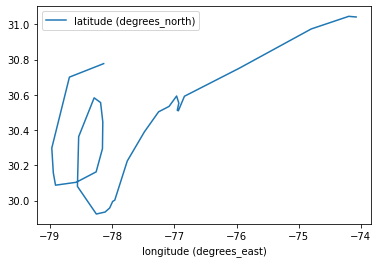

In [3]:
ndf = df.resample("1D").mean()
ndf["time"] = ndf.index.strftime("%Y-%m-%dT%H:%M:%SZ")

ndf.plot(x="longitude (degrees_east)", y="latitude (degrees_north)");

In [4]:
erd_df = ndf[["time", "latitude (degrees_north)", "longitude (degrees_east)"]]
erd_df.columns = ["time", "latitude", "longitude"]

time_lat_lon = erd_df.to_csv(index=False)

In [5]:
from urllib.parse import unquote_plus, quote_plus


erddap_server = "https://coastwatch.pfeg.noaa.gov/erddap"
command = "convert/interpolate.csv?"

time_lat_lon_table = "TimeLatLonTable=time%2Clatitude%2Clongitude%0A2020-01-01T06%3A00%3A00Z%2C35.580%2C-122.550%0A2020-01-01T12%3A00%3A00Z%2C35.576%2C-122.553%0A2020-01-01T18%3A00%3A00Z%2C35.572%2C-122.568%0A2020-01-02T00%3A00%3A00Z%2C35.569%2C-122.571%0A"
time_lat_lon_table = f"TimeLatLonTable={time_lat_lon}"

request = "&requestCSV=jplMURSST41%2Fanalysed_sst%2FBilinear%2F4"

url = f"{time_lat_lon_table}{request}"


unquoted = unquote_plus(url)
print(unquoted)

TimeLatLonTable=time,latitude,longitude
2021-09-18T00:00:00Z,31.0415284,-74.0767652
2021-09-19T00:00:00Z,31.045235074157304,-74.19571627865169
2021-09-20T00:00:00Z,30.973748331707316,-74.79874661463415
2021-09-21T00:00:00Z,30.7513994247191,-75.95385661123595
2021-09-22T00:00:00Z,30.592158453333333,-76.83690204444444
2021-09-23T00:00:00Z,30.509671324444444,-76.93471043555556
2021-09-24T00:00:00Z,30.512786067415732,-76.9521364494382
2021-09-25T00:00:00Z,30.553165922077923,-76.92701739220779
2021-09-26T00:00:00Z,30.593412853932584,-76.96289729438202
2021-09-27T00:00:00Z,30.53456570909091,-77.08399632727273
2021-09-28T00:00:00Z,30.503939466666665,-77.25222378666666
2021-09-29T00:00:00Z,30.39036503111111,-77.48038044444444
2021-09-30T00:00:00Z,30.224735441860467,-77.7561886511628
2021-10-01T00:00:00Z,30.002958471910112,-77.95673499325842
2021-10-02T00:00:00Z,29.995775836363634,-77.99072541818181
2021-10-03T00:00:00Z,29.958422975280897,-78.03892469213483
2021-10-04T00:00:00Z,29.9356361674418

In [6]:
requoted = quote_plus(unquoted.strip("https://"))
interpolated = f"{erddap_server}/{command}{requoted}"

idf = pd.read_csv(interpolated)

idf["saildrone"] = ndf["TEMP_SBE37_MEAN (degree_C)"].values
idf.dropna(inplace=True)

/home/filipe/miniconda3/envs/IOOS/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


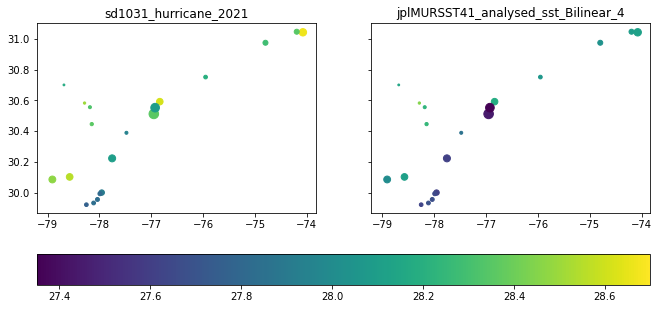

In [7]:
import matplotlib.pyplot as plt


fig, (ax0, ax1) = plt.subplots(
    ncols=2, figsize=(11, 5), sharey=True, sharex=True
)

vmin, vmax = 27.35, 28.7,
diff = idf["saildrone"] - idf["jplMURSST41_analysed_sst_Bilinear_4"]

cs0 = ax0.scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["saildrone"],
    s=diff*1e2,
    vmin=vmin, vmax=vmax,
)
ax0.set_title("sd1031_hurricane_2021")

cs1 = ax1.scatter(
    idf["longitude"],
    idf["latitude"],
    c=idf["jplMURSST41_analysed_sst_Bilinear_4"],
    s=diff*1e2,
    vmin=vmin, vmax=vmax,
    
)
ax1.set_title("jplMURSST41_analysed_sst_Bilinear_4")

fig.colorbar(cs0, ax=[ax0, ax1], location="bottom");